In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

'cuda'

In [20]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=123456789)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=1000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=25)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=20)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=25, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=1000)

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=25, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=20, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=1000)

In [5]:
def generate_1x2_exp_data(num_examples, lambda_1, lambda_2):
    item_one = np.random.exponential(scale=1/lambda_1, size=(num_examples, 1, 1))
    item_two = np.random.exponential(scale=1/lambda_2, size=(num_examples, 1, 1))
    item_one = torch.from_numpy(item_one)
    item_two = torch.from_numpy(item_two)
    
    return torch.cat([item_one, item_two], dim=-1).type(torch.float)

In [6]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = torch.tensor([[[0., np.inf],
                            [0., np.inf]]])
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = generate_1x2_exp_data(args.num_examples, 2.0, 1.0).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [7]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  4%|▍         | 1/25 [01:10<28:10, 70.44s/it]

{'regret_max': 2.7436506748199463, 'regret_mean': 0.027680592611432076, 'regret_mults': tensor([[5.5183]], device='cuda:0'), 'payment': 0.5702241659164429}
{'regret_max': 2.7436506748199463, 'regret_mean': 0.027680592611432076, 'regret_mults': tensor([[5.5183]], device='cuda:0'), 'payment': 0.5702241659164429}


  8%|▊         | 2/25 [02:21<27:01, 70.49s/it]

{'regret_max': 0.27369213104248047, 'regret_mean': 0.007904062047600746, 'regret_mults': tensor([[6.2622]], device='cuda:0'), 'payment': 0.6449552774429321}
{'regret_max': 0.27369213104248047, 'regret_mean': 0.007904062047600746, 'regret_mults': tensor([[6.2622]], device='cuda:0'), 'payment': 0.6449552774429321}


 12%|█▏        | 3/25 [03:31<25:48, 70.37s/it]

{'regret_max': 0.21071624755859375, 'regret_mean': 0.005733549129217863, 'regret_mults': tensor([[7.1646]], device='cuda:0'), 'payment': 0.6442685127258301}
{'regret_max': 0.21071624755859375, 'regret_mean': 0.005733549129217863, 'regret_mults': tensor([[7.1646]], device='cuda:0'), 'payment': 0.6442685127258301}


 16%|█▌        | 4/25 [04:41<24:39, 70.44s/it]

{'regret_max': 0.2366175651550293, 'regret_mean': 0.006214536726474762, 'regret_mults': tensor([[10.4894]], device='cuda:0'), 'payment': 0.6369321346282959}
{'regret_max': 0.2366175651550293, 'regret_mean': 0.006214536726474762, 'regret_mults': tensor([[10.4894]], device='cuda:0'), 'payment': 0.6369321346282959}


 20%|██        | 5/25 [05:52<23:30, 70.52s/it]

{'regret_max': 0.31917667388916016, 'regret_mean': 0.004573000594973564, 'regret_mults': tensor([[11.4590]], device='cuda:0'), 'payment': 0.6278802752494812}
{'regret_max': 0.31917667388916016, 'regret_mean': 0.004573000594973564, 'regret_mults': tensor([[11.4590]], device='cuda:0'), 'payment': 0.6278802752494812}


 24%|██▍       | 6/25 [07:02<22:19, 70.50s/it]

{'regret_max': 0.16046524047851562, 'regret_mean': 0.003702141810208559, 'regret_mults': tensor([[13.5182]], device='cuda:0'), 'payment': 0.6267087459564209}
{'regret_max': 0.16046524047851562, 'regret_mean': 0.003702141810208559, 'regret_mults': tensor([[13.5182]], device='cuda:0'), 'payment': 0.6267087459564209}


 28%|██▊       | 7/25 [08:13<21:10, 70.57s/it]

{'regret_max': 0.18018531799316406, 'regret_mean': 0.003457749728113413, 'regret_mults': tensor([[14.7230]], device='cuda:0'), 'payment': 0.6234514713287354}
{'regret_max': 0.18018531799316406, 'regret_mean': 0.003457749728113413, 'regret_mults': tensor([[14.7230]], device='cuda:0'), 'payment': 0.6234514713287354}


 32%|███▏      | 8/25 [09:24<20:02, 70.73s/it]

{'regret_max': 0.17888641357421875, 'regret_mean': 0.0031860177405178547, 'regret_mults': tensor([[16.9473]], device='cuda:0'), 'payment': 0.6198808550834656}
{'regret_max': 0.17888641357421875, 'regret_mean': 0.0031860177405178547, 'regret_mults': tensor([[16.9473]], device='cuda:0'), 'payment': 0.6198808550834656}


 36%|███▌      | 9/25 [10:35<18:52, 70.76s/it]

{'regret_max': 0.14805841445922852, 'regret_mean': 0.002500508911907673, 'regret_mults': tensor([[17.8062]], device='cuda:0'), 'payment': 0.618389368057251}
{'regret_max': 0.14805841445922852, 'regret_mean': 0.002500508911907673, 'regret_mults': tensor([[17.8062]], device='cuda:0'), 'payment': 0.618389368057251}


 40%|████      | 10/25 [11:46<17:40, 70.70s/it]

{'regret_max': 0.16585779190063477, 'regret_mean': 0.0027302182279527187, 'regret_mults': tensor([[20.1077]], device='cuda:0'), 'payment': 0.6164827346801758}
{'regret_max': 0.16585779190063477, 'regret_mean': 0.0027302182279527187, 'regret_mults': tensor([[20.1077]], device='cuda:0'), 'payment': 0.6164827346801758}


 44%|████▍     | 11/25 [12:56<16:29, 70.71s/it]

{'regret_max': 0.21828556060791016, 'regret_mean': 0.0022587382700294256, 'regret_mults': tensor([[21.9245]], device='cuda:0'), 'payment': 0.6103253960609436}
{'regret_max': 0.21828556060791016, 'regret_mean': 0.0022587382700294256, 'regret_mults': tensor([[21.9245]], device='cuda:0'), 'payment': 0.6103253960609436}


 48%|████▊     | 12/25 [14:07<15:19, 70.76s/it]

{'regret_max': 0.12261486053466797, 'regret_mean': 0.0014604827156290412, 'regret_mults': tensor([[22.2504]], device='cuda:0'), 'payment': 0.6110969185829163}
{'regret_max': 0.12261486053466797, 'regret_mean': 0.0014604827156290412, 'regret_mults': tensor([[22.2504]], device='cuda:0'), 'payment': 0.6110969185829163}


 52%|█████▏    | 13/25 [15:17<14:05, 70.42s/it]

{'regret_max': 0.14362335205078125, 'regret_mean': 0.0017694920534268022, 'regret_mults': tensor([[23.0998]], device='cuda:0'), 'payment': 0.6075272560119629}
{'regret_max': 0.14362335205078125, 'regret_mean': 0.0017694920534268022, 'regret_mults': tensor([[23.0998]], device='cuda:0'), 'payment': 0.6075272560119629}


 56%|█████▌    | 14/25 [16:27<12:53, 70.31s/it]

{'regret_max': 0.10036277770996094, 'regret_mean': 0.0012150087859481573, 'regret_mults': tensor([[24.8557]], device='cuda:0'), 'payment': 0.607082724571228}
{'regret_max': 0.10036277770996094, 'regret_mean': 0.0012150087859481573, 'regret_mults': tensor([[24.8557]], device='cuda:0'), 'payment': 0.607082724571228}


 60%|██████    | 15/25 [17:36<11:38, 69.89s/it]

{'regret_max': 0.17951583862304688, 'regret_mean': 0.0017243206966668367, 'regret_mults': tensor([[27.0941]], device='cuda:0'), 'payment': 0.6045247316360474}
{'regret_max': 0.17951583862304688, 'regret_mean': 0.0017243206966668367, 'regret_mults': tensor([[27.0941]], device='cuda:0'), 'payment': 0.6045247316360474}


 64%|██████▍   | 16/25 [18:45<10:26, 69.56s/it]

{'regret_max': 0.3079814910888672, 'regret_mean': 0.004868399351835251, 'regret_mults': tensor([[27.4388]], device='cuda:0'), 'payment': 0.5779491662979126}
{'regret_max': 0.3079814910888672, 'regret_mean': 0.004868399351835251, 'regret_mults': tensor([[27.4388]], device='cuda:0'), 'payment': 0.5779491662979126}


 68%|██████▊   | 17/25 [19:53<09:14, 69.35s/it]

{'regret_max': 0.08123302459716797, 'regret_mean': 0.0006686331471428275, 'regret_mults': tensor([[27.9584]], device='cuda:0'), 'payment': 0.6041383147239685}
{'regret_max': 0.08123302459716797, 'regret_mean': 0.0006686331471428275, 'regret_mults': tensor([[27.9584]], device='cuda:0'), 'payment': 0.6041383147239685}


 72%|███████▏  | 18/25 [21:02<08:03, 69.13s/it]

{'regret_max': 0.0735931396484375, 'regret_mean': 0.0005730119883082807, 'regret_mults': tensor([[29.2763]], device='cuda:0'), 'payment': 0.6063235998153687}
{'regret_max': 0.0735931396484375, 'regret_mean': 0.0005730119883082807, 'regret_mults': tensor([[29.2763]], device='cuda:0'), 'payment': 0.6063235998153687}


 76%|███████▌  | 19/25 [22:11<06:54, 69.02s/it]

{'regret_max': 0.08259773254394531, 'regret_mean': 0.0005801159422844648, 'regret_mults': tensor([[29.6993]], device='cuda:0'), 'payment': 0.6064863801002502}
{'regret_max': 0.08259773254394531, 'regret_mean': 0.0005801159422844648, 'regret_mults': tensor([[29.6993]], device='cuda:0'), 'payment': 0.6064863801002502}


 80%|████████  | 20/25 [23:20<05:44, 68.97s/it]

{'regret_max': 0.07520341873168945, 'regret_mean': 0.0007069705752655864, 'regret_mults': tensor([[30.0994]], device='cuda:0'), 'payment': 0.6060471534729004}
{'regret_max': 0.07520341873168945, 'regret_mean': 0.0007069705752655864, 'regret_mults': tensor([[30.0994]], device='cuda:0'), 'payment': 0.6060471534729004}


 84%|████████▍ | 21/25 [24:28<04:35, 68.83s/it]

{'regret_max': 0.11033248901367188, 'regret_mean': 0.0010632709600031376, 'regret_mults': tensor([[30.6894]], device='cuda:0'), 'payment': 0.6035730838775635}
{'regret_max': 0.11033248901367188, 'regret_mean': 0.0010632709600031376, 'regret_mults': tensor([[30.6894]], device='cuda:0'), 'payment': 0.6035730838775635}


 88%|████████▊ | 22/25 [25:37<03:26, 68.85s/it]

{'regret_max': 0.11339950561523438, 'regret_mean': 0.0006477849092334509, 'regret_mults': tensor([[31.6962]], device='cuda:0'), 'payment': 0.6061369180679321}
{'regret_max': 0.11339950561523438, 'regret_mean': 0.0006477849092334509, 'regret_mults': tensor([[31.6962]], device='cuda:0'), 'payment': 0.6061369180679321}


 92%|█████████▏| 23/25 [26:46<02:17, 68.83s/it]

{'regret_max': 0.06628799438476562, 'regret_mean': 0.0005703389761038125, 'regret_mults': tensor([[32.5725]], device='cuda:0'), 'payment': 0.6065053939819336}
{'regret_max': 0.06628799438476562, 'regret_mean': 0.0005703389761038125, 'regret_mults': tensor([[32.5725]], device='cuda:0'), 'payment': 0.6065053939819336}


 96%|█████████▌| 24/25 [27:55<01:08, 68.93s/it]

{'regret_max': 0.10073375701904297, 'regret_mean': 0.0008433668408542871, 'regret_mults': tensor([[33.0046]], device='cuda:0'), 'payment': 0.6025573015213013}
{'regret_max': 0.10073375701904297, 'regret_mean': 0.0008433668408542871, 'regret_mults': tensor([[33.0046]], device='cuda:0'), 'payment': 0.6025573015213013}


100%|██████████| 25/25 [29:04<00:00, 69.77s/it]

{'regret_max': 0.10294151306152344, 'regret_mean': 0.0009498674771748483, 'regret_mults': tensor([[42.0128]], device='cuda:0'), 'payment': 0.59858238697052}
CPU times: user 28min 49s, sys: 6.78 s, total: 28min 56s
Wall time: 29min 4s
{'regret_max': 0.10294151306152344, 'regret_mean': 0.0009498674771748483, 'regret_mults': tensor([[42.0128]], device='cuda:0'), 'payment': 0.59858238697052}
CPU times: user 28min 49s, sys: 6.78 s, total: 28min 56s
Wall time: 29min 4s


In [8]:
dir_name = 'exponential_1x2_0_inf_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [21]:
test_data = generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device)

In [22]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [00:39, 39.35s/it]

CPU times: user 39 s, sys: 153 ms, total: 39.2 s
Wall time: 39.4 s


{'payment_mean': 0.6072574853897095,
 'regret_mean': 0.00042545219184830785,
 'regret_max': 0.017521381378173828}

1it [00:39, 39.35s/it]

CPU times: user 39 s, sys: 153 ms, total: 39.2 s
Wall time: 39.4 s


{'payment_mean': 0.6072574853897095,
 'regret_mean': 0.00042545219184830785,
 'regret_max': 0.017521381378173828}

In [23]:
def exponential_1x2_0_inf_optimal_mechanism_deterministic(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] + bids[i, :, 1] > 1.2286 and bids[i, :, 0] + bids[i, :, 1] - 1.2286 > bids[i, :, 0] - 0.9288:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 1.2286
        elif bids[i, :, 0] - 0.9288 > 0:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = .9288
    return allocs, payments

opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism_deterministic(test_data)
opt_payments.mean()

tensor(0.6254)

tensor(0.6254)

In [24]:
def exponential_1x2_0_inf_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        bid_one = bids[i, :, 0]
        bid_two = bids[i, : , 1]
        combined_bid = bid_one + bid_two
        if combined_bid > 1.2319:
            if combined_bid - 1.2319 > bid_one - 1 and combined_bid - 1.2319 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 1])
                payments[i, :] = 1.2319
            elif bid_one - 1 >= combined_bid - 1.2319 and bid_one - 1 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 0])
                payments[i, :] = 1.
            else: 
                allocs[i, 0, :] = torch.tensor([0, .5])
                payments[i, :] = 1.
        elif bid_one > 1 and bid_one - 1 > bid_two * .5 - 1:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 1.
        elif bid_two * .5 > 1:
            allocs[i, 0, :] = torch.tensor([0, .5])
            payments[i, :] = 1.
    return allocs, payments
opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.6265)

tensor(0.6265)

In [25]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
# model.sinkhorn_rounds = 20
# model.sinkhorn_epsilon = 1e-1

random_starts = [test_data]
for i in range(10):
    random_starts.append(generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [03:36, 216.00s/it]

CPU times: user 3min 34s, sys: 788 ms, total: 3min 35s
Wall time: 3min 36s



1it [03:36, 216.00s/it]

{'payment_mean': 0.6072574257850647,
 'regret_mean': 0.00042929468327201903,
 'regret_max': 0.01752185821533203}

CPU times: user 3min 34s, sys: 788 ms, total: 3min 35s
Wall time: 3min 36s


{'payment_mean': 0.6072574257850647,
 'regret_mean': 0.00042929468327201903,
 'regret_max': 0.01752185821533203}

In [26]:
model.save(dir_name)

In [27]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [28]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    ext = [item1_min, item1_max, item2_min, item2_max]
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

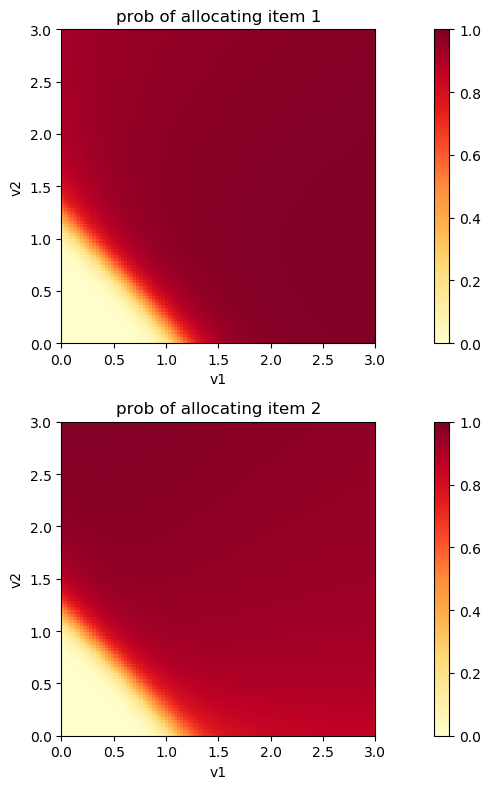

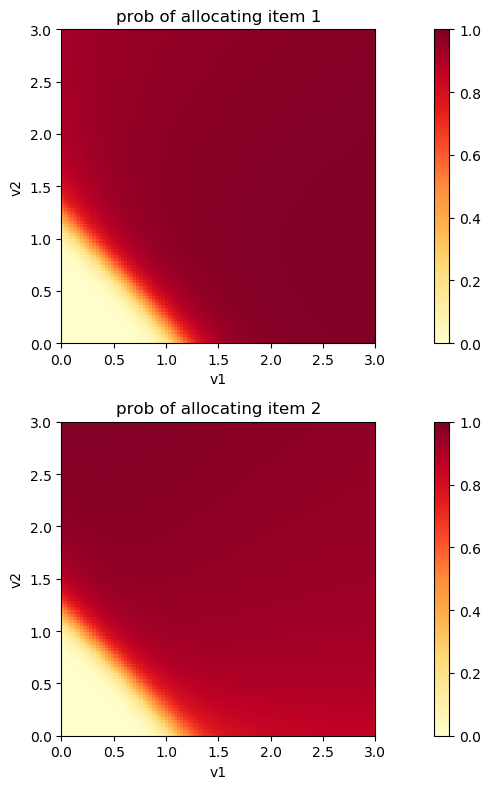

In [29]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
# cpu_model.sinkhorn_rounds = 100
# cpu_model.sinkhorn_epsilon = 1e-1
plot_12_model(cpu_model, 0.01, (0,3), (0,3))

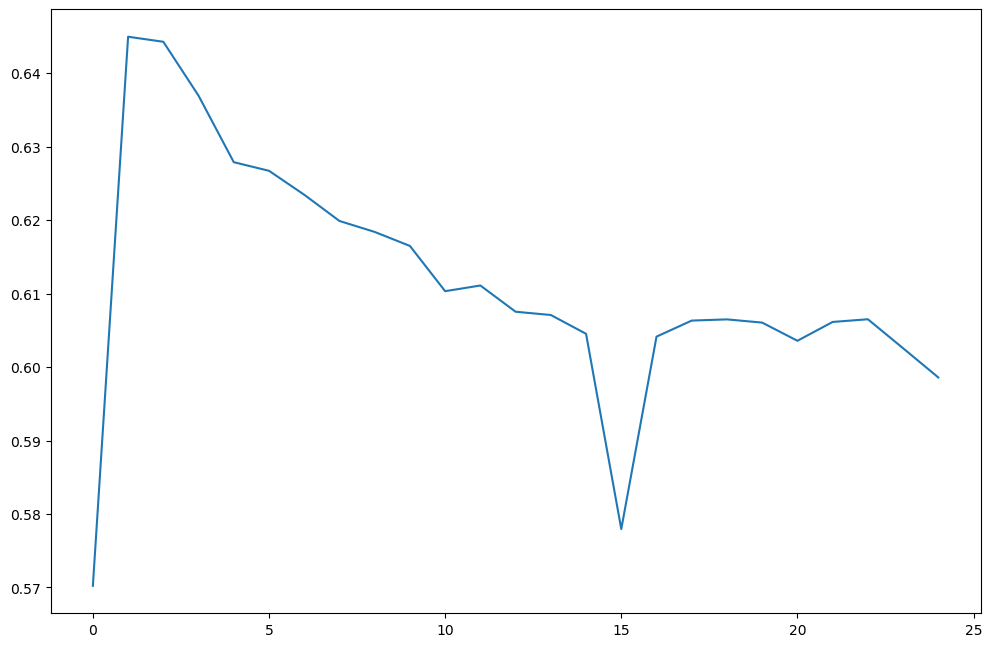

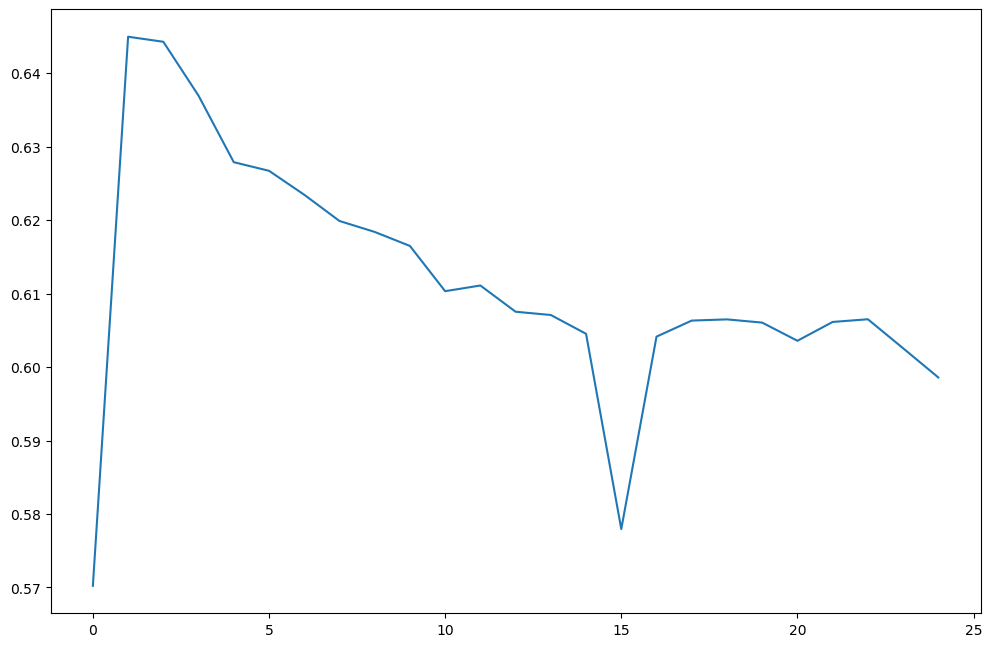

In [30]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [31]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)